In [1]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example aims at showing characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. The last dataset is an example of a 'null'
situation for clustering: the data is homogeneous, and
there is no good clustering.

While these examples give some intuition about the algorithms,
this intuition might not apply to very high dimensional data.

The results could be improved by tweaking the parameters for
each clustering strategy, for instance setting the number of
clusters for the methods that needs this parameter
specified. Note that affinity propagation has a tendency to
create many clusters. Thus in this example its two parameters
(damping and per-point preference) were set to mitigate this
behavior.


In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets as dt
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
np.random.seed(0)

In [20]:
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = dt.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = dt.make_moons(n_samples=n_samples, noise=.05)
blobs = dt.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'KMeans', 'GM',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

datasets = [noisy_circles, noisy_moons, blobs, no_structure]

In [29]:
def plot(n_clusters = 2):
    clustering_names = ['MiniBatchKMeans', 'KMeans', 'GM','SpectralClustering', 'Ward', 'AgglomerativeClustering','DBSCAN', 'Birch']

    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    plot_num = 1
    
    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # create clustering estimators
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
        kmeans = cluster.KMeans(n_clusters=n_clusters)
        gm = GaussianMixture(n_components=n_clusters)
        ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                               connectivity=connectivity)
        spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=.2)
        affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                           preference=-200)

        average_linkage = cluster.AgglomerativeClustering(
            linkage="average", affinity="cityblock", n_clusters=n_clusters,
            connectivity=connectivity)

        birch = cluster.Birch(n_clusters=n_clusters)
        clustering_algorithms = [
            two_means, kmeans, gm, spectral, ward, average_linkage,
            dbscan, birch]

        for name, algorithm in zip(clustering_names, clustering_algorithms):
            # predict cluster memberships
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            # plot
            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)
            plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

            if hasattr(algorithm, 'cluster_centers_'):
                centers = algorithm.cluster_centers_
                center_colors = colors[:len(centers)]
                plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
            plot_num += 1
    plt.show()

In [31]:
def plot_selected(n_clusters = 2):
    clustering_names = ['MiniBatchKMeans', 'KMeans', 'GM','SpectralClustering']
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    plot_num = 1
    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # create clustering estimators
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
        kmeans = cluster.KMeans(n_clusters=n_clusters)
        gm = GaussianMixture(n_components=n_clusters)
        spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
        clustering_algorithms = [two_means, kmeans, gm, spectral]
        for name, algorithm in zip(clustering_names, clustering_algorithms):
            # predict cluster memberships
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            # plot
            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)
            plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

            if hasattr(algorithm, 'cluster_centers_'):
                centers = algorithm.cluster_centers_
                center_colors = colors[:len(centers)]
                plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
            plot_num += 1
    plt.show()

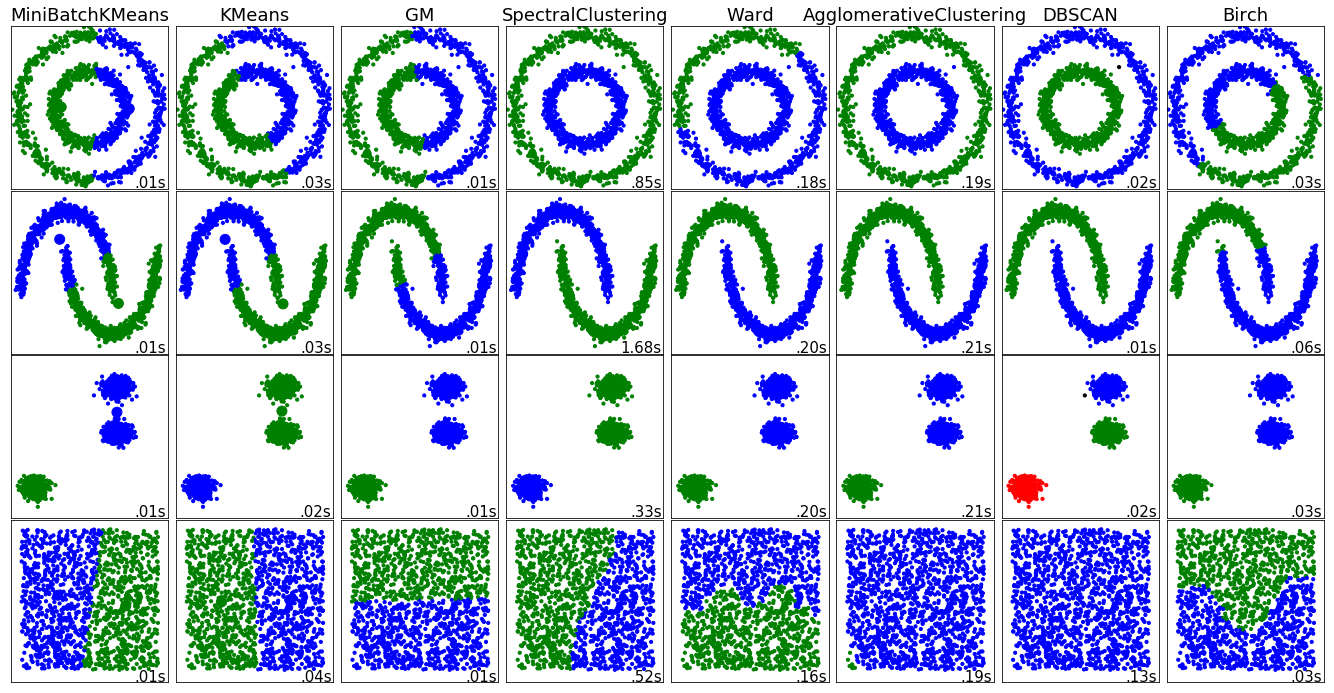

In [22]:
plot()

/home/buzz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cluster/birch.py:602: UserWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters))


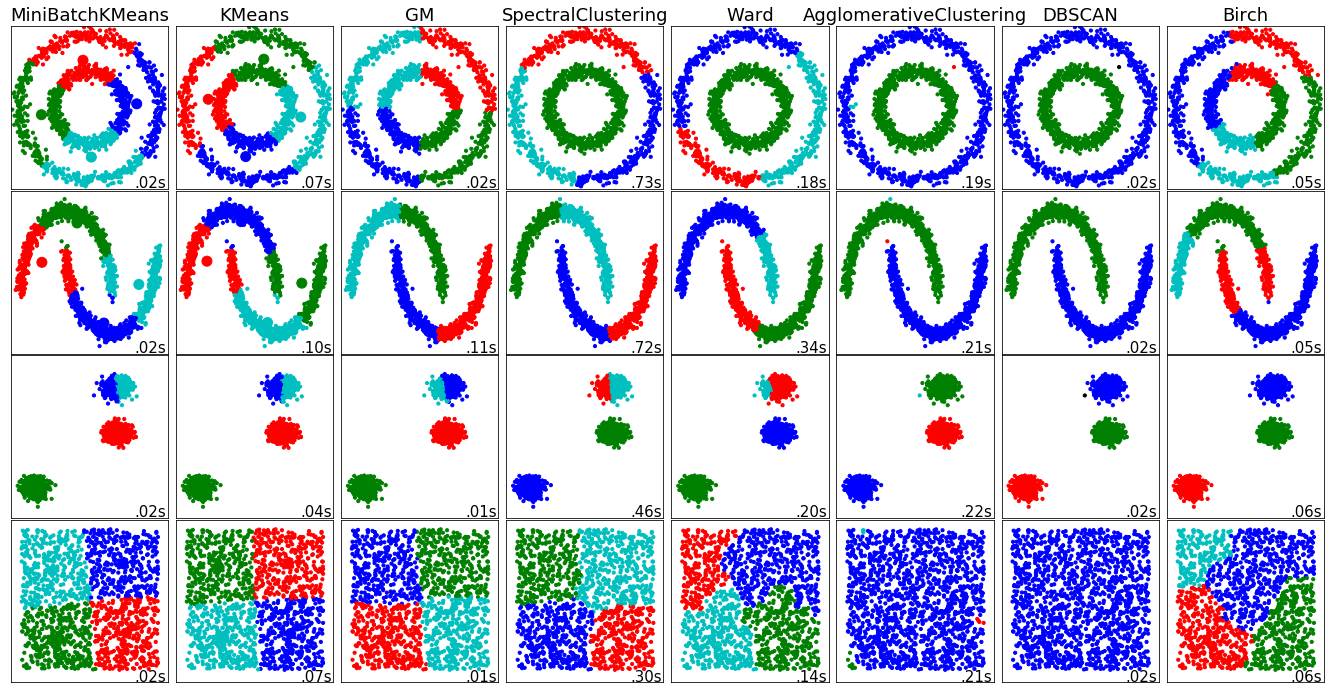

In [23]:
plot(4)

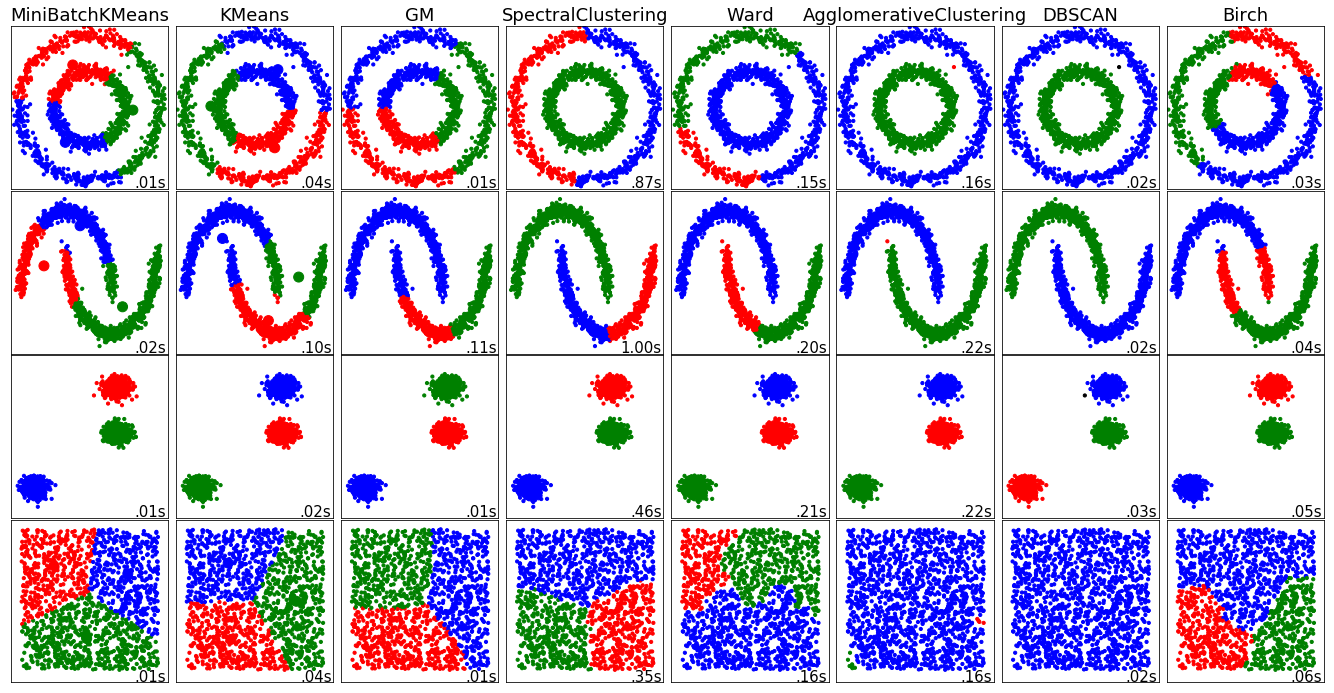

In [25]:
plot(3)

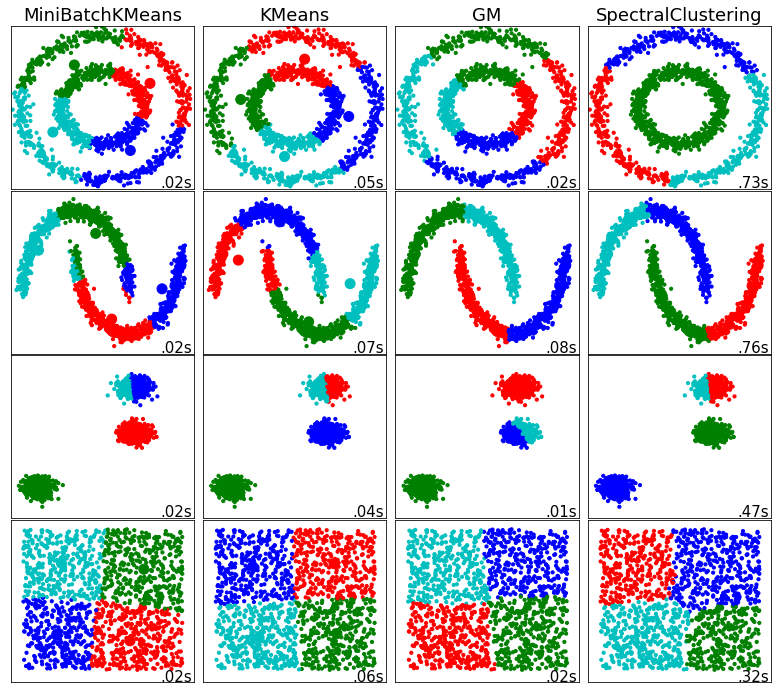

In [32]:
plot_selected(4)